# FP-6: Machine Learning (Regression)

This notebook adds **machine learning with validation** to the Final Project.

**Goal:** predict `Liking` from measurable brewing variables and sensory descriptors using a simple regression model, and evaluate generalization performance using a held-out test set and k-fold cross-validation.

> Keep `main.ipynb` to TWO results only. This notebook can include more detail and extra checks.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error


In [2]:
DATA_PATH = "data.csv"
df = pd.read_csv(DATA_PATH)

df.shape, df.columns.tolist()

((3186, 48),
 ['Judge',
  'Cluster',
  'Week',
  'Session Number',
  'Position',
  'Brew',
  'Temp.x',
  'TDS.x',
  'PE.x',
  'Dose',
  'Setting',
  'Grind',
  'Empty Carafe',
  'Full Carafe',
  'Brew Mass',
  'TDS__1',
  'Percent Extraction',
  'pH',
  'Initial NaOH',
  'Final NaOH',
  'Titration pH',
  'Volume',
  'Brew Temperature',
  'Pour Temp',
  '90Sec Temp',
  'Liking',
  'Temp',
  'Flavor.intensity',
  'Acidity',
  'Mouthfeel',
  'Tea.floral',
  'Fruit',
  'Citrus',
  'Green.veg',
  'Paper.wood',
  'Burnt',
  'Cereal',
  'Nutty',
  'Dark.chocolate',
  'Caramel',
  'Bitter',
  'Astringent',
  'Roasted',
  'Sour',
  'Thick.viscous',
  'Sweet',
  'Rubber',
  'Purchase.intent'])

In [3]:
df["Liking"].describe()

count    3186.000000
mean        5.851538
std         1.739266
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max         9.000000
Name: Liking, dtype: float64

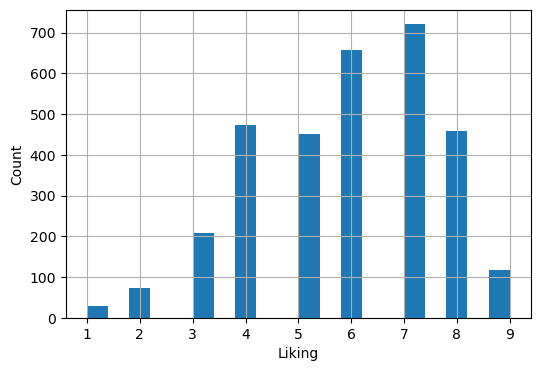

In [4]:
plt.figure(figsize=(6,4))
plt.hist(df["Liking"].dropna(), bins=20)
plt.xlabel("Liking")
plt.ylabel("Count")
plt.grid(True)
plt.show()


## 1. Feature set (X) and target (y)

To keep this assignment **interpretable**, we start with a small set of mostly numeric/binary columns:

- Brewing / measured variables (numeric): `Dose`, `Grind`, `Brew Mass`, `Percent Extraction`, `pH`, `Volume`, `Brew Temperature`, `Pour Temp`, `90Sec Temp`
- Sensory ratings (numeric): `Flavor.intensity`, `Acidity`, `Mouthfeel`
- Binary flavor notes (0/1): `Fruit`, `Bitter`, `Astringent`, `Sour`, `Sweet`


In [5]:
target = "Liking"
feature_cols = [
    "Dose", "Grind", "Brew Mass", "Percent Extraction", "pH", "Volume",
    "Brew Temperature", "Pour Temp", "90Sec Temp",
    "Flavor.intensity", "Acidity", "Mouthfeel",
    "Fruit", "Bitter", "Astringent", "Sour", "Sweet"
]

# Keep only columns that actually exist
feature_cols = [c for c in feature_cols if c in df.columns]

X = df[feature_cols].copy()
y = df[target].copy()

# Ensure numeric; coerce errors to NaN (then impute)
X = X.apply(pd.to_numeric, errors="coerce")
y = pd.to_numeric(y, errors="coerce")

if "Flavor.intensity" in X.columns:
    X["Flavor.intensity_sq"] = X["Flavor.intensity"] ** 2
feature_cols = X.columns.tolist()
X.shape, y.shape, feature_cols


((3186, 18),
 (3186,),
 ['Dose',
  'Grind',
  'Brew Mass',
  'Percent Extraction',
  'pH',
  'Volume',
  'Brew Temperature',
  'Pour Temp',
  '90Sec Temp',
  'Flavor.intensity',
  'Acidity',
  'Mouthfeel',
  'Fruit',
  'Bitter',
  'Astringent',
  'Sour',
  'Sweet',
  'Flavor.intensity_sq'])

## 2. Train / test split (hold-out validation)

A single train/test split is the required validation:
- Train set: used to fit the model
- Test set: **never used in training**, only used for final evaluation


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((2548, 18), (638, 18))

## 3. Model

We use a simple linear model.

- `LinearRegression` gives an interpretable baseline.
- We standardize numeric features for stability/interpretability (coefficients become comparable).
- Missing values are imputed with the median.

We also try `Ridge` (L2-regularized linear regression) as a sanity check to reduce overfitting.


In [7]:
numeric_features = feature_cols

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), numeric_features),
    ],
    remainder="drop"
)

lin_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

ridge_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=1.0, random_state=42))
])

lin_model


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Dose', 'Grind', 'Brew Mass',
                                                   'Percent Extraction', 'pH',
                                                   'Volume', 'Brew Temperature',
                                                   'Pour Temp', '90Sec Temp',
                                                   'Flavor.intensity',
                                                   'Acidity', 'Mouthfeel',
                                                   'Fruit', 'Bitter',
                                                   'Astringent', 'Sour',
                                                   'Sweet',
                                                   'Flavor.intensity_sq'])])),
                ('model', LinearRegression())])

## 4. Evaluation on the held-out test set

Metrics:
- **R²**: fraction of variance explained (higher is better)
- **RMSE**: typical prediction error in the same units as `Liking` (lower is better)

We also compare against a **baseline** that predicts the training mean for every example.


In [8]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Baseline (mean predictor)
baseline_pred = np.full_like(y_test, fill_value=np.nanmean(y_train), dtype=float)
baseline_r2 = r2_score(y_test, baseline_pred)
baseline_rmse = rmse(y_test, baseline_pred)

# Linear regression
lin_model.fit(X_train, y_train)
lin_pred = lin_model.predict(X_test)
lin_r2 = r2_score(y_test, lin_pred)
lin_rmse = rmse(y_test, lin_pred)

# Ridge regression
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)
ridge_r2 = r2_score(y_test, ridge_pred)
ridge_rmse = rmse(y_test, ridge_pred)

results = pd.DataFrame({
    "Model": ["Baseline (mean)", "LinearRegression", "Ridge(alpha=1)"],
    "Test R2": [baseline_r2, lin_r2, ridge_r2],
    "Test RMSE": [baseline_rmse, lin_rmse, ridge_rmse],
})

results


,Model,Test R2,Test RMSE
0,Baseline (mean),-0.009891,1.768085
1,LinearRegression,0.319310,1.451579
2,Ridge(alpha=1),0.320470,1.450341


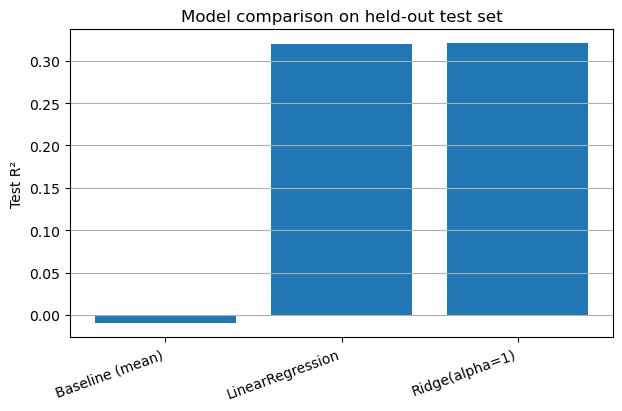

In [9]:
plt.figure(figsize=(7,4))
plt.bar(results["Model"], results["Test R2"])
plt.ylabel("Test R²")
plt.title("Model comparison on held-out test set")
plt.xticks(rotation=20, ha="right")
plt.grid(True, axis="y")
plt.show()


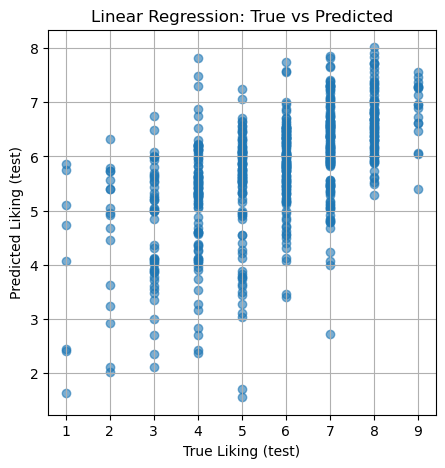

In [10]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, lin_pred, alpha=0.6)
plt.xlabel("True Liking (test)")
plt.ylabel("Predicted Liking (test)")
plt.title("Linear Regression: True vs Predicted")
plt.grid(True)
plt.show()


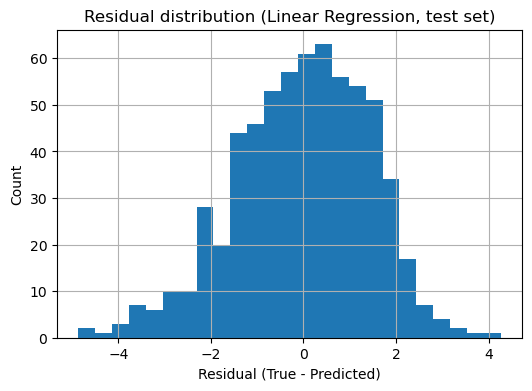

In [11]:
residuals = y_test - lin_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=25)
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Count")
plt.title("Residual distribution (Linear Regression, test set)")
plt.grid(True)
plt.show()


## 5. K-fold cross-validation (stronger validation)

A single split can be noisy. To strengthen validation, we do **5-fold CV** on the training set.

We report mean and standard deviation of R² across folds.


In [12]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

lin_cv_r2 = cross_val_score(lin_model, X_train, y_train, cv=cv, scoring="r2")
ridge_cv_r2 = cross_val_score(ridge_model, X_train, y_train, cv=cv, scoring="r2")

cv_summary = pd.DataFrame({
    "Model": ["LinearRegression", "Ridge(alpha=1)"],
    "CV R2 mean": [lin_cv_r2.mean(), ridge_cv_r2.mean()],
    "CV R2 std": [lin_cv_r2.std(), ridge_cv_r2.std()],
})

cv_summary


,Model,CV R2 mean,CV R2 std
0,LinearRegression,0.328382,0.016426
1,Ridge(alpha=1),0.328361,0.016711


## 6. Interpreting coefficients (insight)

Because we standardized features, coefficients roughly indicate **relative importance** in a linear sense.

Caution:
- Correlated features can make individual coefficients unstable.
- Linear models can't capture complex nonlinear taste interactions.


In [13]:
# Extract standardized coefficients from the linear regression pipeline
# (works because preprocess outputs a fixed numeric matrix in the same order)
lin_fitted = lin_model.named_steps["model"]
coef = lin_fitted.coef_
coef_df = pd.DataFrame({"feature": numeric_features, "coef": coef}).sort_values("coef")

coef_df


,feature,coef
17,Flavor.intensity_sq,-3.262996
15,Sour,-0.272442
0,Dose,-0.175045
14,Astringent,-0.168218
13,Bitter,-0.155815
2,Brew Mass,-0.102013
6,Brew Temperature,-0.070121
10,Acidity,-0.037882
3,Percent Extraction,-0.025921
7,Pour Temp,-0.018165


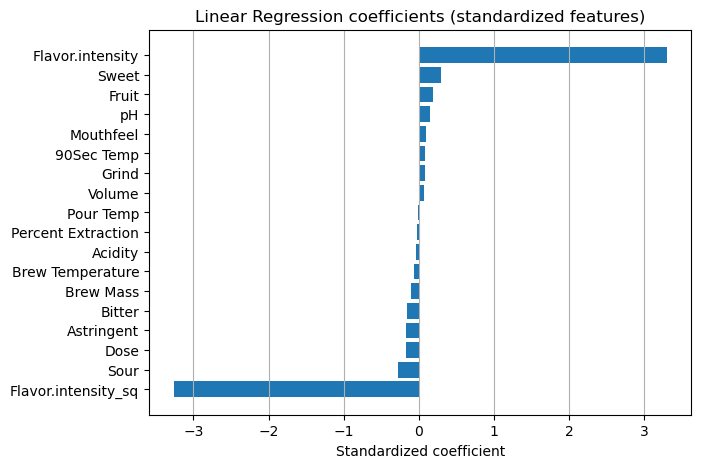

In [14]:
plt.figure(figsize=(7,5))
plt.barh(coef_df["feature"], coef_df["coef"])
plt.xlabel("Standardized coefficient")
plt.title("Linear Regression coefficients (standardized features)")
plt.grid(True, axis="x")
plt.show()


## 7. Notes for your `main.ipynb` (two results only)

Good candidates for the TWO main results:
1. **True vs Predicted** scatter plot on the **test set**
2. **Coefficient bar chart** (standardized coefficients)

In `main.ipynb`, keep text short: define the question, show the two figures, and state the key takeaway.
